<a href="https://colab.research.google.com/github/daywatch/deep_learning_with_pytorch_and_tensorflow/blob/main/tensorflow_convolutional_neural_network_malaria_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Dataset loading**

Use an segmented cell image to diagnose malaria

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError, BinaryAccuracy,TrueNegatives, TruePositives,FalseNegatives,FalsePositives,Precision, Recall, AUC
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization, Input, Layer
from google.colab import drive
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

In [ ]:
# images: 86x86, each cell ranges from 0 to 255 (normalized by 255)

# https://www.tensorflow.org/datasets/catalog/malaria


# https://www.tensorflow.org/datasets/api_docs/python/tfds/load
dataset, dataset_info = tfds.load('malaria', with_info=True,
                                  as_supervised=True, 
                                  shuffle_files = True, 
                                  split=['train'])
dataset #need to use the 1st element as dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [ ]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
dataset_size = len(dataset)

# train_dataset =  dataset.take(int(train_ratio * dataset_size))
# val_test_dataset = dataset.skip(int(train_ratio * dataset_size))
# val_dataset = val_test_dataset.take(int(val_ratio * dataset_size))

# test_dataset = val_test_dataset.skip(int(val_ratio * dataset_size))

# print(len(train_dataset))
# print(len(val_dataset))
# print(len(test_dataset))


def split(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = split(dataset[0], train_ratio, val_ratio, test_ratio)

In [ ]:
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# dataset_info

In [ ]:
for data in dataset[0].take(1):
  print(data)

(<tf.Tensor: shape=(145, 148, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


# Data Visualization

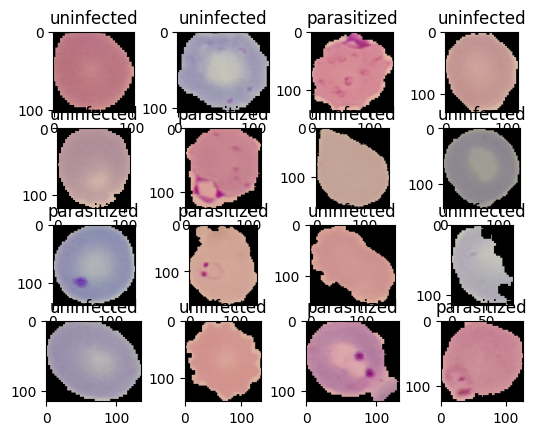

In [ ]:
for i, (image,label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4,4,i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))

# Data preprocessing (resizing&rescaling, batch, shuffling)

In [ ]:
# make the same width and height for all images + normalize
# normalization in this proj is x = (x-xmin)/(xmax-xmin); x/255 > rescaling

In [ ]:
IM_SIZE = 224
def resize_rescale(image, label): 
  return tf.image.resize(image,(IM_SIZE,IM_SIZE))/255.0,label

In [ ]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [ ]:
for image, label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(0, shape=(), dtype=int64)


In [ ]:
# batch and reshuffling

batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
batch_size = 32 
val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(batch_size).prefetch(tf.data.AUTOTUNE)



# Model creation

In [ ]:
# similar to the LeNet design
# https://en.wikipedia.org/wiki/Convolutional_neural_network#/media/File:Comparison_image_neural_networks.svg

tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE,IM_SIZE,3)),
    Conv2D(filters=6, kernel_size=5, strides = 1, padding = 'valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=3, strides = 1, padding = 'valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    Dense(100, activation='relu'),
    BatchNormalization(),
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid'), #two classes maps to 1, not 2

])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 6)       456       
                                                                 
 batch_normalization (BatchN  (None, 220, 220, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 108, 108, 16)     64        
 hNormalization)                                                 
                                                        

# Binary crossentropy (when compiling)

In [ ]:
# other metrics: AUC, Precision, ...
metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'), 
            BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

model.compile(
    optimizer = Adam(learning_rate=0.01),
    loss = BinaryCrossentropy(),
    metrics = metrics
)


# Training

In [ ]:
history = model.fit(train_dataset,validation_data=val_dataset,epochs=3,verbose=1)

Epoch 1/10
689/689 [==============================] - 64s 81ms/step - loss: 0.4088 - accuracy: 0.8141 - val_loss: 0.4127 - val_accuracy: 0.8897
Epoch 2/10
689/689 [==============================] - 47s 68ms/step - loss: 0.2184 - accuracy: 0.9252 - val_loss: 0.1865 - val_accuracy: 0.9379
Epoch 3/10
689/689 [==============================] - 48s 70ms/step - loss: 0.1994 - accuracy: 0.9330 - val_loss: 0.2501 - val_accuracy: 0.9172
Epoch 4/10
689/689 [==============================] - 55s 79ms/step - loss: 0.1864 - accuracy: 0.9352 - val_loss: 0.4570 - val_accuracy: 0.8682
Epoch 5/10
689/689 [==============================] - 48s 69ms/step - loss: 0.1707 - accuracy: 0.9424 - val_loss: 0.3149 - val_accuracy: 0.9136
Epoch 6/10
689/689 [==============================] - 47s 68ms/step - loss: 0.1580 - accuracy: 0.9468 - val_loss: 0.2093 - val_accuracy: 0.9230
Epoch 7/10
689/689 [==============================] - 48s 70ms/step - loss: 0.1520 - accuracy: 0.9483 - val_loss: 0.1735 - val_accuracy:

# Model creation with functional API

In [ ]:
# split the original model into two sub-models

func_input = Input(shape = (IM_SIZE,IM_SIZE,3),name='input image')

x = Conv2D(filters=6, kernel_size=5, strides = 1, padding = 'valid', activation='relu')(func_input)
x = BatchNormalization()(x)
x =  MaxPool2D(pool_size=2, strides=2)(x)

x = Conv2D(filters=16, kernel_size=3, strides = 1, padding = 'valid', activation='relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size=2, strides=2)(x)


feature_extractor = Model(func_input,output,name="feature_extractor")
feature_extractor.summary()

Model: "feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 220, 220, 6)       456       
                                                                 
 batch_normalization_4 (Batc  (None, 220, 220, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 110, 110, 6)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 108, 108, 16)      880       
                                                                 
 batch_normalization_5 (Batc  (None, 108, 108, 16

In [ ]:
x = feature_extractor(func_input) # input goes into the previous values; or sequential models like feature_extractor_seq_model

x = Flatten()(x)

x = Dense(100, activation='relu')(x)
x= BatchNormalization()(x)

x = Dense(10, activation='relu')(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation='sigmoid')(x)

model_api2 = Model(func_input,func_output,name="model_api2")
model_api2.summary()

Model: "model_api2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (Function  (None, 54, 54, 16)       1424      
 al)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 46656)             0         
                                                                 
 dense_3 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_6 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 10)                1

In [ ]:
# mix sequential with function apis


feature_extractor_seq_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE,IM_SIZE,3)),
    Conv2D(filters=6, kernel_size=5, strides = 1, padding = 'valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=3, strides = 1, padding = 'valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

])
feature_extractor_seq_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 220, 220, 6)       456       
                                                                 
 batch_normalization_8 (Batc  (None, 220, 220, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 110, 110, 6)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 108, 108, 16)      880       
                                                                 
 batch_normalization_9 (Batc  (None, 108, 108, 16)     64        
 hNormalization)                                                 
                                                      

# Model subclassing

method1

In [ ]:
#FeatureExtractor(Layer)
#init
#call

class FeatureExtractor(Layer): #define and then call
  #def __init__(self):
  def __init__(self, filters, kernel_size, strides, padding, activation,pool_size):
    super(FeatureExtractor, self).__init__()

    self.conv1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch1 = BatchNormalization()
    self.pool1 = MaxPool2D(pool_size=pool_size, strides=2*strides)

    self.conv2 = Conv2D(filters = filters*2, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch2 = BatchNormalization()
    self.pool2 = MaxPool2D(pool_size=pool_size, strides=2*strides)

  def call(self,x):
    x = self.conv1(x)
    x = self.batch1(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.batch2(x)
    x = self.pool2(x)

    return x

feature_sub_class = FeatureExtractor(
    filters = 8, 
    kernel_size = 3, 
    strides = 1, 
    padding = 'valid', 
    activation = 'relu',
    pool_size =2
    )


In [ ]:
# test the previous subclass
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = feature_sub_class(func_input)

x = Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (FeatureE  (None, 54, 54, 16)       1488      
 xtractor)                                                       
                                                                 
 flatten_2 (Flatten)         (None, 46656)             0         
                                                                 
 dense_6 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_12 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dense_7 (Dense)             (None, 10)                

method2

In [ ]:
# instead of putting layers in the model, we can put model within model

class LenetModel(Model): 
  def __init__(self):
    super(LenetModel, self).__init__()

    self.feature_extractor = FeatureExtractor(
                                filters = 8, 
                                kernel_size = 3, 
                                strides = 1, 
                                padding = 'valid', 
                                activation = 'relu',
                                pool_size =2
                                )
    self.flatten = Flatten()
    self.dense1 = Dense(100, activation = "relu")
    self.batch1 = BatchNormalization()

    self.dense2 = Dense(10, activation = "relu")
    self.batch2 = BatchNormalization()

    self.dense3 = Dense(1, activation = "sigmoid")

  def call(self,x):
    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense1(x)
    x = self.batch1(x)
    x = self.dense2(x)
    x = self.batch2(x)
    x = self.dense3(x)

    return x


lenet_method2 = LenetModel()
lenet_method2(tf.zeros([1,224,224,3])) #need to put some valid inputs
lenet_method2.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_1 (Featur  multiple                 1488      
 eExtractor)                                                     
                                                                 
 flatten_3 (Flatten)         multiple                  0         
                                                                 
 dense_9 (Dense)             multiple                  4665700   
                                                                 
 batch_normalization_16 (Bat  multiple                 400       
 chNormalization)                                                
                                                                 
 dense_10 (Dense)            multiple                  1010      
                                                                 
 batch_normalization_17 (Bat  multiple                 

# Custom layers

In [ ]:
# example: x > Wx +B > y
# x has dim (Batch_size, feature_size), so W has to be (feature_size, output_dim) for multiplciation
# output is (B,output_dim)

class NeuralLearnDense(Layer):
  def __init__(self, output_units,activation):
    super(NeuralLearnDense, self).__init__()

    self.output_units = output_units
    self.activation = activation

  def build(self,input_features_shape):
    self.w = self.add_weight(shape=(input_features_shape[-1],self.output_units),
                                   initializer="random_normal",trainable=True) #it's a Layer function,input_features_shape[-1] is (F) in (B,F)
    self.b = self.add_weight(shape=(self.output_units,),
                                  initializer="random_normal",
                                  trainable=True)

  def call(self, input_features):
    if (self.activation == "relu"):
      return tf.nn.relu(tf.matmul(input_features,self.w) + self.b)

    if (self.activation == "sigmoid"):
      return tf.math.sigmoid(tf.matmul(input_features,self.w) + self.b)

    else:
      return tf.matmul(input_features,self.w) + self.biases


In [ ]:
# test integration using sequential

model_customL = tf.keras.Sequential([
    
    InputLayer(input_shape = (IM_SIZE,IM_SIZE,3)),
    Conv2D(filters=6, kernel_size=5, strides = 1, padding = 'valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=3, strides = 1, padding = 'valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    NeuralLearnDense(100, activation='relu'),
    BatchNormalization(),
    NeuralLearnDense(10, activation='relu'),
    BatchNormalization(),
    NeuralLearnDense(1, activation='sigmoid'), #two classes maps to 1, not 2

])
model_customL.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 220, 220, 6)       456       
                                                                 
 batch_normalization_18 (Bat  (None, 220, 220, 6)      24        
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 110, 110, 6)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 108, 108, 16)      880       
                                                                 
 batch_normalization_19 (Bat  (None, 108, 108, 16)     64        
 chNormalization)                                                
                                                      

# Accuracy and loss

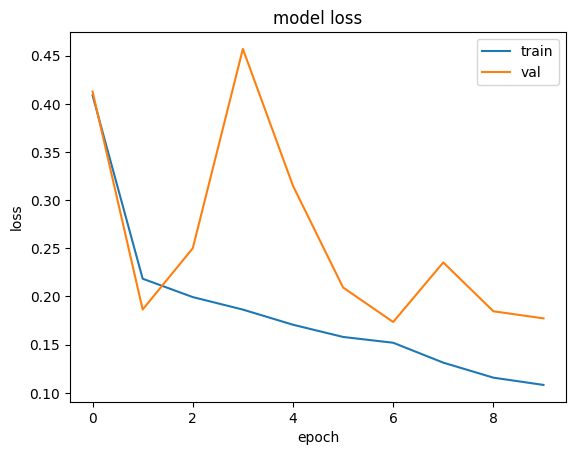

In [ ]:
# plot loss history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'])
plt.show()

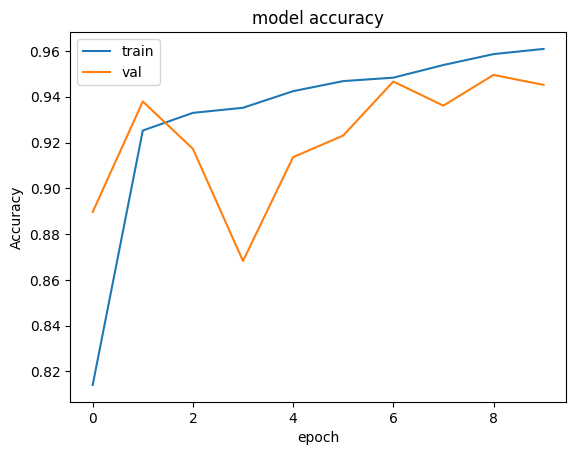

In [ ]:
# plot loss history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'])
plt.show()

# Evaluation on testing data

In [ ]:
test_dataset = test_dataset.batch(1) #batch dim is missing, so added None to 224,224,3
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
model.evaluate(test_dataset)

2757/2757 [==============================] - 23s 4ms/step - loss: 0.1912 - accuracy: 0.9460


[0.19116629660129547, 0.945955753326416]

In [ ]:
# model prediction

model.predict(test_dataset.take(1))[0][0]

1/1 [==============================] - 11s 11s/step


1.1121862e-05

In [ ]:
def parasite_or_not(x):
  if x < 0.5 :
    return str('Parasite')
  else:
    return str('Healthy')
parasite_or_not(model.predict(test_dataset.take(2))[0][0])

2/2 [==============================] - 11s 9ms/step


'Healthy'

1/1 [==============================] - 0s 21ms/step


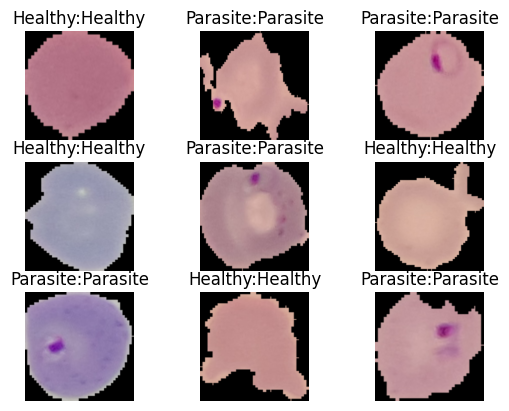

In [ ]:
# test on 9 inputs
for i, (image,label) in enumerate(test_dataset.take(9)):

  ax = plt.subplot(3,3, i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(model.predict(image)[0][0])))
  
  plt.axis('off')


# Confusion matrix and ROC plots

In [ ]:
# get two types of Ys
labels = []
input_list = []
for x,y in test_dataset.as_numpy_iterator():
  labels.append(y)
  input_list.append(x)
labels = np.array([item[0] for item in labels])
input_list = np.array(input_list)[:,0,...]


label_pred = model.predict(input_list)[:,0]

87/87 [==============================] - 2s 19ms/step


Need to get rid of useless dimension of the inputs
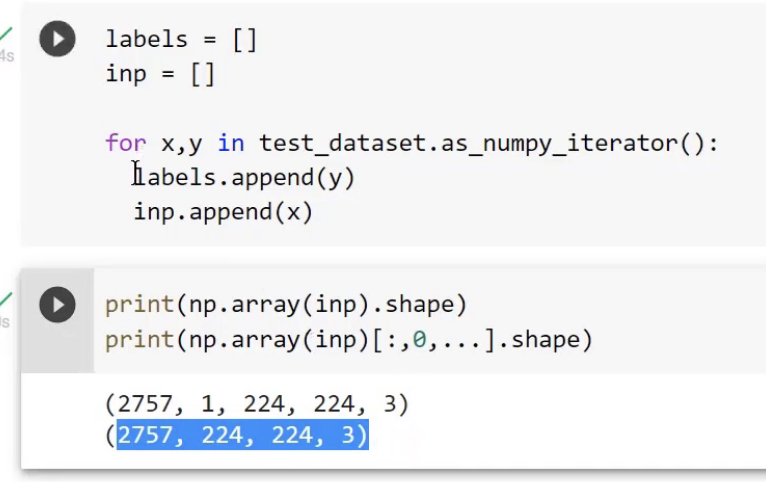

[[1315   80]
 [  69 1293]]


Text(0.5, 58.7222222222222, 'Predicted')

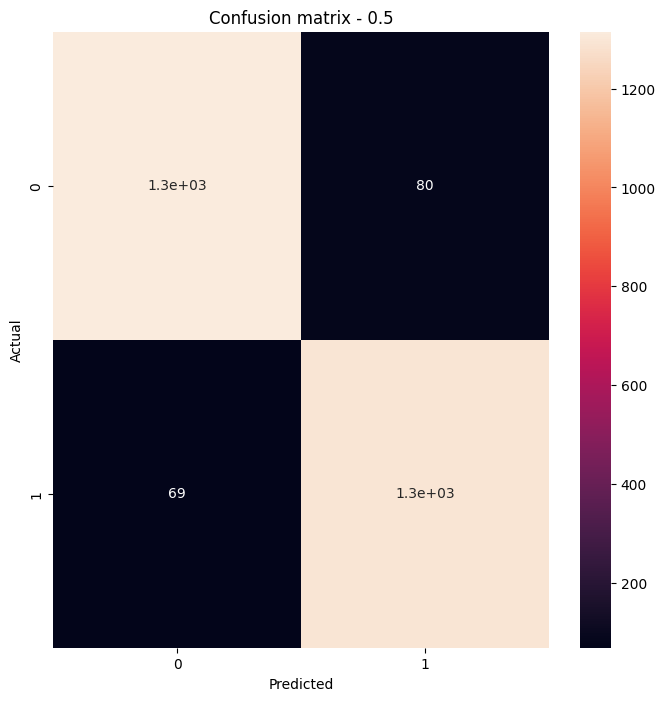

In [ ]:
threshold = 0.5 # for classification
# tweak the threshhold for lower FN rate

cm = confusion_matrix(labels, label_pred > threshold)
print(cm)
plt.figure(figsize=(8,8))

# sns plot
sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix - {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')


# ROC plot

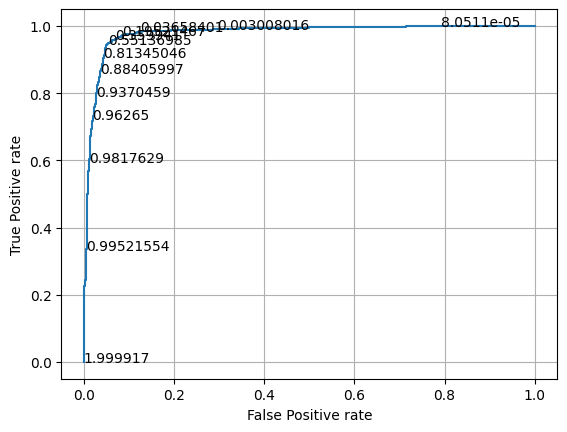

In [ ]:
fp, tp, thresholds = roc_curve(labels, label_pred)
plt.plot(fp, tp)
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")

plt.grid()

skip = 20

for i in range(0, len(thresholds), skip): #skip datapoints
  plt.text(fp[i], tp[i], thresholds[i])
  
plt.show()

# Saving and loading models in Google Drive

In [ ]:
# two saving options: 1.save config/hyperparameters + weights 2.only weights
# weights are more important

model.save('LenetSavedModel')
# model.save('LenetSavedModel.hdf5')

In [ ]:
lenet_loaded = tf.keras.models.load_model('LenetSavedModel')
lenet_loaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 6)       456       
                                                                 
 batch_normalization (BatchN  (None, 220, 220, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 108, 108, 16)     64        
 hNormalization)                                                 
                                                        

In [ ]:
# only weights

#model.save_weights("weights/lenet_weights")
#lenet_weights_model = model.load_weights("weights/lenet_weights")

In [ ]:
# save the model to Google Drive

#drive.mount('/content/drive/')

In [ ]:
 #!cp -r /content/weights /content/drive/MyDrive/